# 🎓 Kaggle Agents + MLE-bench Lite

**Notebook para TCC**: Avaliação de Agentes Autônomos em 22 Competições do MLE-bench Lite

Este notebook:
1. Usa os dados do MLE-bench (split validável)
2. Executa o workflow do kaggle-agents
3. Valida as submissões com `mlebench grade-sample`
4. Gera relatório consolidado

## 1. Environment Setup

In [1]:
# Check GPU
!nvidia-smi || echo "No GPU available (CPU mode)"

Sun Dec  7 19:12:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Clone repositories
!git clone https://github.com/gustavogomespl/kaggle-agents.git
!git clone https://github.com/openai/mle-bench.git

%cd kaggle-agents

Cloning into 'kaggle-agents'...
remote: Enumerating objects: 1358, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 1358 (delta 284), reused 306 (delta 158), pack-reused 905 (from 1)
Receiving objects: 100% (1358/1358), 674.86 KiB | 25.96 MiB/s, done.
Resolving deltas: 100% (871/871), done.
Cloning into 'mle-bench'...
remote: Enumerating objects: 1393, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 1393 (delta 151), reused 112 (delta 97), pack-reused 1145 (from 1)
Receiving objects: 100% (1393/1393), 772.63 KiB | 19.32 MiB/s, done.
Resolving deltas: 100% (348/348), done.
Filtering content: 100% (286/286), 36.36 MiB | 2.41 MiB/s, done.
/content/kaggle-agents


In [3]:
# Install dependencies
!pip install -q uv
!uv pip install --system -e .
!uv pip install --system langgraph langchain-openai pandas numpy scikit-learn matplotlib seaborn

# Install MLE-bench
!pip install -q -e ../mle-bench

print("✓ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 68.2 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 215 packages in 1.65s
Prepared 52 packages in 2.27s
Uninstalled 5 packages in 31ms
Installed 52 packages in 68ms
 + anthropic==0.75.0
 + asyncer==0.0.8
 + backoff==2.2.1
 + bcrypt==5.0.0
 + build==1.3.0
 + catboost==1.2.8
 + category-encoders==2.9.0
 + chromadb==1.3.5
 + coloredlogs==15.0.1
 + colorlog==6.10.1
 + dataclasses-json==0.6.7
 + diskcache==5.6.3
 + dspy==3.0.4
 + dspy-ai==3.0.4
 + durationpy==0.10
 + fastuuid==0.14.0
 + feature-engine==1.9.3
 + filetype==1.2.0
 + gepa==0.0.17
 - google-ai-generativelanguage==0.6.15
 + google-ai-generativelanguage==0.9.0
 - grpcio==1.76.0
 + grpcio==1.67.1
 - grpcio-status==1.71.2
 + grpcio-status==1.67.1
 + httptools==0.7.1
 + humanfriendly==10.0
 + json-repair==0.54.2
 + kaggle-agents==0.1.0 (from file:///content/kaggle-agents)
 + kubernetes==34.1.0
 + langchain-anthropic==1.2.0
 + langchain-classic==1.0.0
 + lan

## 2. Configuration

In [4]:
import os
from pathlib import Path

# ============================================================
# CONFIGURAÇÃO PRINCIPAL - EDITE AQUI
# ============================================================

# LLM Provider global
LLM_PROVIDER = "openai"
LLM_MODEL = "gpt-5.1-codex-mini"
LLM_TEMPERATURE = 1
LLM_MAX_TOKENS = 16000

# Overrides por papel
PLANNER_PROVIDER = "openai"
PLANNER_MODEL = "gpt-5-mini"
DEVELOPER_PROVIDER = "openai"
DEVELOPER_MODEL = "gpt-5.1-codex-mini"
EVALUATOR_PROVIDER = "openai"
EVALUATOR_MODEL = "gpt-5-mini"

# Workflow Settings
MAX_ITERATIONS = 3
TARGET_PERCENTILE = 20.0

# Colab Secrets
try:
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY') or ""
    ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY') or ""
    KAGGLE_USERNAME = userdata.get('KAGGLE_USERNAME') or ""
    KAGGLE_KEY = userdata.get('KAGGLE_KEY') or ""
    print("✓ Loaded secrets from Colab")
except Exception:
    from getpass import getpass
    print("⚠️ Colab secrets not found. Using manual input.")
    OPENAI_API_KEY = getpass("OpenAI API Key: ")
    ANTHROPIC_API_KEY = getpass("Anthropic API Key (optional): ") or ""
    KAGGLE_USERNAME = input("Kaggle Username: ")
    KAGGLE_KEY = getpass("Kaggle Key: ")

# Save .env
env_content = f"""# Kaggle Agents + MLE-bench Configuration
LLM_PROVIDER={LLM_PROVIDER}
LLM_MODEL={LLM_MODEL}
LLM_TEMPERATURE={LLM_TEMPERATURE}
LLM_MAX_TOKENS={LLM_MAX_TOKENS}
PLANNER_PROVIDER={PLANNER_PROVIDER}
PLANNER_MODEL={PLANNER_MODEL}
DEVELOPER_PROVIDER={DEVELOPER_PROVIDER}
DEVELOPER_MODEL={DEVELOPER_MODEL}
EVALUATOR_PROVIDER={EVALUATOR_PROVIDER}
EVALUATOR_MODEL={EVALUATOR_MODEL}
OPENAI_API_KEY={OPENAI_API_KEY}
ANTHROPIC_API_KEY={ANTHROPIC_API_KEY}
KAGGLE_USERNAME={KAGGLE_USERNAME}
KAGGLE_KEY={KAGGLE_KEY}
KAGGLE_AUTO_SUBMIT=false
MAX_ITERATIONS={MAX_ITERATIONS}
TARGET_PERCENTILE={TARGET_PERCENTILE}
LOG_LEVEL=INFO
LOG_DIR=./logs
"""

with open('.env', 'w') as f:
    f.write(env_content)

# Setup Kaggle credentials
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)
(kaggle_dir / 'kaggle.json').write_text(f'{{"username":"{KAGGLE_USERNAME}","key":"{KAGGLE_KEY}"}}')
!chmod 600 ~/.kaggle/kaggle.json

print("✓ Configuration saved")

✓ Loaded secrets from Colab
✓ Configuration saved


In [5]:
# LangSmith Tracing (opcional)
try:
    from google.colab import userdata
    langchain_api_key = userdata.get('LANGSMITH')
    langsmith_project = userdata.get('LANGSMITH_PROJECT') or "kaggle-agents-mlebench"

    if langchain_api_key:
        os.environ["LANGCHAIN_TRACING_V2"] = "true"
        os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
        os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
        os.environ["LANGCHAIN_PROJECT"] = langsmith_project
        print(f"✓ LangSmith Tracing Enabled (Project: {langsmith_project})")
    else:
        print("ℹ️ LangSmith Tracing Disabled")
except:
    print("ℹ️ LangSmith Tracing Disabled")

✓ LangSmith Tracing Enabled (Project: default)


## 3. MLE-bench Lite Competitions

22 competições do benchmark lite (~158GB total)

In [6]:
# Lista completa das 22 competições do MLE-bench Lite
MLEBENCH_LITE_COMPETITIONS = [
    # Image Classification
    {"id": "aerial-cactus-identification", "category": "Image Classification", "size_gb": 0.0254},
    {"id": "aptos2019-blindness-detection", "category": "Image Classification", "size_gb": 10.22},
    {"id": "dog-breed-identification", "category": "Image Classification", "size_gb": 0.75},
    {"id": "dogs-vs-cats-redux-kernels-edition", "category": "Image Classification", "size_gb": 0.85},
    {"id": "leaf-classification", "category": "Image Classification", "size_gb": 0.036},
    {"id": "plant-pathology-2020-fgvc7", "category": "Image Classification", "size_gb": 0.8},
    {"id": "ranzcr-clip-catheter-line-classification", "category": "Image Classification", "size_gb": 13.13},  # Known issue
    {"id": "siim-isic-melanoma-classification", "category": "Image Classification", "size_gb": 116.16},

    # Image To Image / Regression
    {"id": "denoising-dirty-documents", "category": "Image To Image", "size_gb": 0.06},
    {"id": "histopathologic-cancer-detection", "category": "Image Regression", "size_gb": 7.76},

    # Text Classification
    {"id": "detecting-insults-in-social-commentary", "category": "Text Classification", "size_gb": 0.002},
    {"id": "jigsaw-toxic-comment-classification-challenge", "category": "Text Classification", "size_gb": 0.06},  # Known issue: crowded
    {"id": "random-acts-of-pizza", "category": "Text Classification", "size_gb": 0.003},
    {"id": "spooky-author-identification", "category": "Text Classification", "size_gb": 0.0019},

    # Tabular
    {"id": "new-york-city-taxi-fare-prediction", "category": "Tabular", "size_gb": 5.7},
    {"id": "nomad2018-predict-transparent-conductors", "category": "Tabular", "size_gb": 0.00624},
    {"id": "tabular-playground-series-dec-2021", "category": "Tabular", "size_gb": 0.7},  # Known issue: crowded
    {"id": "tabular-playground-series-may-2022", "category": "Tabular", "size_gb": 0.57},  # Known issue: crowded

    # Audio
    {"id": "mlsp-2013-birds", "category": "Audio Classification", "size_gb": 0.5851},
    {"id": "the-icml-2013-whale-challenge-right-whale-redux", "category": "Audio Classification", "size_gb": 0.29314},

    # Seq->Seq
    {"id": "text-normalization-challenge-english-language", "category": "Seq->Seq", "size_gb": 0.01},
    {"id": "text-normalization-challenge-russian-language", "category": "Seq->Seq", "size_gb": 0.01},
]

print(f"Total: {len(MLEBENCH_LITE_COMPETITIONS)} competições")
print(f"Tamanho total: {sum(c['size_gb'] for c in MLEBENCH_LITE_COMPETITIONS):.2f} GB")

# Mostrar lista
import pandas as pd
df_competitions = pd.DataFrame(MLEBENCH_LITE_COMPETITIONS)
print("\n")
display(df_competitions)

Total: 22 competições
Tamanho total: 157.73 GB




,id,category,size_gb
0,aerial-cactus-identification,Image Classification,0.02540
1,aptos2019-blindness-detection,Image Classification,10.22000
2,dog-breed-identification,Image Classification,0.75000
3,dogs-vs-cats-redux-kernels-edition,Image Classification,0.85000
4,leaf-classification,Image Classification,0.03600
5,plant-pathology-2020-fgvc7,Image Classification,0.80000
6,ranzcr-clip-catheter-line-classification,Image Classification,13.13000
7,siim-isic-melanoma-classification,Image Classification,116.16000
8,denoising-dirty-documents,Image To Image,0.06000
9,histopathologic-cancer-detection,Image Regression,7.76000


In [7]:
# ============================================================
# SELECIONE QUAIS COMPETIÇÕES RODAR
# ============================================================

# Opção 1: Rodar TODAS as 22 (vai demorar muito!)
# COMPETITIONS_TO_RUN = [c['id'] for c in MLEBENCH_LITE_COMPETITIONS]

# Opção 2: Rodar apenas algumas (recomendado para teste)
COMPETITIONS_TO_RUN = [
    "aerial-cactus-identification",     # Pequena, rápida (~25MB)
    # "leaf-classification",              # Pequena (~36MB)
    # "spooky-author-identification",     # Texto, pequena (~2MB)
    # "detecting-insults-in-social-commentary",  # Texto, muito pequena (~2MB)
    # "dog-breed-identification",         # Média (~750MB)
]

# Opção 3: Rodar por categoria
# COMPETITIONS_TO_RUN = [c['id'] for c in MLEBENCH_LITE_COMPETITIONS if c['category'] == 'Image Classification']

# Opção 4: Rodar as menores (< 1GB)
# COMPETITIONS_TO_RUN = [c['id'] for c in MLEBENCH_LITE_COMPETITIONS if c['size_gb'] < 1.0]

print(f"\n🎯 Competições selecionadas: {len(COMPETITIONS_TO_RUN)}")
for comp in COMPETITIONS_TO_RUN:
    info = next(c for c in MLEBENCH_LITE_COMPETITIONS if c['id'] == comp)
    print(f"   - {comp} ({info['category']}, {info['size_gb']} GB)")


🎯 Competições selecionadas: 1
   - aerial-cactus-identification (Image Classification, 0.0254 GB)


## 4. Prepare MLE-bench Datasets

In [8]:
import subprocess
from pathlib import Path

MLE_CACHE = Path("/root/.cache/mle-bench/data")

print("="*60)
print("PREPARANDO DATASETS DO MLE-BENCH")
print("="*60)

for i, comp_id in enumerate(COMPETITIONS_TO_RUN, 1):
    print(f"\n[{i}/{len(COMPETITIONS_TO_RUN)}] Preparando: {comp_id}")

    comp_cache = MLE_CACHE / comp_id / "prepared"

    if comp_cache.exists():
        print(f"   ✓ Já preparado")
    else:
        result = subprocess.run(
            ["mlebench", "prepare", "-c", comp_id],
            capture_output=True,
            text=True
        )
        if result.returncode == 0:
            print(f"   ✓ Preparado com sucesso")
        else:
            print(f"   ❌ Erro: {result.stderr[:200]}")

print("\n" + "="*60)
print("✓ Preparação concluída!")

PREPARANDO DATASETS DO MLE-BENCH

[1/1] Preparando: aerial-cactus-identification
   ✓ Preparado com sucesso

✓ Preparação concluída!


## 5. Helper Functions

In [9]:
import json
import shutil
import zipfile
import pandas as pd
from pathlib import Path
from datetime import datetime

MLE_CACHE = Path("/root/.cache/mle-bench/data")
WORKSPACE = Path("/content/kaggle_competitions")

def setup_mlebench_data(competition_id: str) -> dict:
    """
    Configura os dados do MLE-bench para uma competição.
    Copia os dados do MLE-bench para o workspace do kaggle-agents.

    Retorna dict com informações sobre os dados.
    """
    mle_dir = MLE_CACHE / competition_id / "prepared"
    public_dir = mle_dir / "public"
    private_dir = mle_dir / "private"

    comp_workspace = WORKSPACE / "competitions" / competition_id
    comp_workspace.mkdir(parents=True, exist_ok=True)

    print(f"\n📁 Configurando dados para: {competition_id}")

    # Extrair ZIPs se necessário
    for zip_file in public_dir.glob("*.zip"):
        extract_dir = public_dir / zip_file.stem
        if not extract_dir.exists():
            print(f"   Extraindo: {zip_file.name}")
            with zipfile.ZipFile(zip_file, 'r') as z:
                z.extractall(public_dir)

    # Copiar arquivos para workspace
    for item in public_dir.iterdir():
        dest = comp_workspace / item.name
        if item.is_file() and not dest.exists():
            shutil.copy2(item, dest)
        elif item.is_dir() and not dest.exists():
            shutil.copytree(item, dest)

    # Copiar description.md como contexto
    if (public_dir / "description.md").exists():
        shutil.copy2(public_dir / "description.md", comp_workspace / "description.md")

    # Encontrar arquivos importantes
    train_csv = None
    sample_sub = None
    test_csv = None

    for f in comp_workspace.glob("*.csv"):
        if "train" in f.name.lower():
            train_csv = f
        elif "sample" in f.name.lower() and "submission" in f.name.lower():
            sample_sub = f
        elif "test" in f.name.lower():
            test_csv = f

    # Info sobre ground truth (para validação posterior)
    gt_file = None
    for pattern in ["test.csv", "answers.csv", "solution.csv"]:
        gt = private_dir / pattern
        if gt.exists():
            gt_file = gt
            break

    info = {
        "competition_id": competition_id,
        "workspace": str(comp_workspace),
        "mle_cache": str(mle_dir),
        "train_csv": str(train_csv) if train_csv else None,
        "sample_submission": str(sample_sub) if sample_sub else None,
        "test_csv": str(test_csv) if test_csv else None,
        "ground_truth": str(gt_file) if gt_file else None,
    }

    print(f"   ✓ Workspace: {comp_workspace}")
    print(f"   ✓ Train: {train_csv.name if train_csv else 'N/A'}")
    print(f"   ✓ Sample submission: {sample_sub.name if sample_sub else 'N/A'}")

    return info


def validate_with_mlebench(competition_id: str, submission_path: str) -> dict:
    """
    Valida uma submissão usando MLE-bench.
    Retorna o resultado da validação.
    """
    import subprocess

    result = subprocess.run(
        ["mlebench", "grade-sample", submission_path, competition_id],
        capture_output=True,
        text=True
    )

    # Parse JSON do output
    output = result.stdout + result.stderr

    # Encontrar JSON no output
    try:
        json_start = output.find("{")
        json_end = output.rfind("}") + 1
        if json_start >= 0 and json_end > json_start:
            json_str = output[json_start:json_end]
            return json.loads(json_str)
    except:
        pass

    return {
        "competition_id": competition_id,
        "valid_submission": False,
        "error": output[:500]
    }


def get_problem_type(competition_id: str) -> tuple:
    """
    Retorna (problem_type, evaluation_metric) baseado na competição.
    """
    # Mapeamento baseado nas competições do MLE-bench Lite
    mappings = {
        # Image Classification (binary)
        "aerial-cactus-identification": ("binary_classification", "auc"),
        "dogs-vs-cats-redux-kernels-edition": ("binary_classification", "log_loss"),
        "histopathologic-cancer-detection": ("binary_classification", "auc"),
        "siim-isic-melanoma-classification": ("binary_classification", "auc"),

        # Image Classification (multiclass)
        "aptos2019-blindness-detection": ("multiclass_classification", "quadratic_weighted_kappa"),
        "dog-breed-identification": ("multiclass_classification", "log_loss"),
        "leaf-classification": ("multiclass_classification", "log_loss"),
        "plant-pathology-2020-fgvc7": ("multiclass_classification", "auc"),
        "ranzcr-clip-catheter-line-classification": ("multilabel_classification", "auc"),

        # Image To Image
        "denoising-dirty-documents": ("regression", "rmse"),

        # Text Classification
        "detecting-insults-in-social-commentary": ("binary_classification", "auc"),
        "jigsaw-toxic-comment-classification-challenge": ("multilabel_classification", "auc"),
        "random-acts-of-pizza": ("binary_classification", "auc"),
        "spooky-author-identification": ("multiclass_classification", "log_loss"),

        # Tabular
        "new-york-city-taxi-fare-prediction": ("regression", "rmse"),
        "nomad2018-predict-transparent-conductors": ("regression", "rmsle"),
        "tabular-playground-series-dec-2021": ("regression", "rmse"),
        "tabular-playground-series-may-2022": ("regression", "rmse"),

        # Audio
        "mlsp-2013-birds": ("multilabel_classification", "auc"),
        "the-icml-2013-whale-challenge-right-whale-redux": ("binary_classification", "auc"),

        # Seq->Seq
        "text-normalization-challenge-english-language": ("seq2seq", "accuracy"),
        "text-normalization-challenge-russian-language": ("seq2seq", "accuracy"),
    }

    return mappings.get(competition_id, ("binary_classification", "auc"))

print("✓ Helper functions loaded")

✓ Helper functions loaded


## 6. Run Kaggle Agents Workflow

In [10]:
from kaggle_agents.core import solve_competition
import time
import traceback

# Resultados
all_results = []

print("="*70)
print("🚀 INICIANDO AVALIAÇÃO MLE-BENCH LITE")
print(f"   Competições: {len(COMPETITIONS_TO_RUN)}")
print(f"   Max iterations: {MAX_ITERATIONS}")
print("="*70)

for idx, competition_id in enumerate(COMPETITIONS_TO_RUN, 1):
    print(f"\n{'#'*70}")
    print(f"# [{idx}/{len(COMPETITIONS_TO_RUN)}] {competition_id}")
    print(f"{'#'*70}")

    start_time = time.time()
    result = {
        "competition_id": competition_id,
        "started_at": datetime.now().isoformat(),
        "status": "pending"
    }

    try:
        # 1. Setup MLE-bench data
        data_info = setup_mlebench_data(competition_id)

        # 2. Get problem type
        problem_type, eval_metric = get_problem_type(competition_id)
        print(f"\n📊 Problem: {problem_type}, Metric: {eval_metric}")

        # 3. Run kaggle-agents workflow
        print(f"\n🤖 Executando solve_competition...")

        agent_result = solve_competition(
            competition_name=competition_id,
            competition_description=f"Solve {competition_id} competition",
            problem_type=problem_type,
            evaluation_metric=eval_metric,
            max_iterations=MAX_ITERATIONS,
        )

        result["agent_result"] = agent_result
        result["status"] = "completed"

        # 4. Find submission file
        workspace = Path(data_info["workspace"])
        submission_files = list(workspace.glob("*submission*.csv")) + list(workspace.glob("submission.csv"))

        if submission_files:
            submission_path = str(submission_files[0])
            print(f"\n📄 Submission: {submission_path}")

            # 5. Validate with MLE-bench
            print(f"\n🔍 Validando com MLE-bench...")
            validation = validate_with_mlebench(competition_id, submission_path)
            result["mlebench_validation"] = validation

            print(f"\n📊 Resultado MLE-bench:")
            print(f"   Valid: {validation.get('valid_submission', False)}")
            print(f"   Score: {validation.get('score', 'N/A')}")
            print(f"   Gold: {validation.get('gold_medal', False)}")
            print(f"   Silver: {validation.get('silver_medal', False)}")
            print(f"   Bronze: {validation.get('bronze_medal', False)}")
            print(f"   Above Median: {validation.get('above_median', False)}")
        else:
            result["status"] = "no_submission"
            print(f"\n❌ Nenhuma submissão encontrada!")

    except Exception as e:
        result["status"] = "error"
        result["error"] = str(e)
        result["traceback"] = traceback.format_exc()
        print(f"\n❌ Erro: {e}")

    # Tempo
    elapsed = time.time() - start_time
    result["elapsed_seconds"] = elapsed
    result["finished_at"] = datetime.now().isoformat()

    print(f"\n⏱️ Tempo: {elapsed/60:.1f} minutos")

    all_results.append(result)

    # Salvar resultados parciais
    with open("/content/mlebench_results.json", "w") as f:
        json.dump(all_results, f, indent=2, default=str)

print("\n" + "="*70)
print("✓ AVALIAÇÃO CONCLUÍDA!")
print("="*70)

🚀 INICIANDO AVALIAÇÃO MLE-BENCH LITE
   Competições: 1
   Max iterations: 3

######################################################################
# [1/1] aerial-cactus-identification
######################################################################

📁 Configurando dados para: aerial-cactus-identification
   Extraindo: test.zip
   Extraindo: train.zip
   ✓ Workspace: /content/kaggle_competitions/competitions/aerial-cactus-identification
   ✓ Train: train.csv
   ✓ Sample submission: sample_submission.csv

📊 Problem: binary_classification, Metric: auc

🤖 Executando solve_competition...
📍 Colab environment detected, using: /content/kaggle_competitions


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ < KAGGLE AGENTS - Autonomous Competition Solving                                                                │
│                                                                                                                 │
│ Competition: aerial-cactus-identification                                                                       │
│ Problem Type: binary_classification                                                                             │
│ Metric: auc                                                                                                     │
│ Goal: Top 20% (Percentile d 20)                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

KAGGLE AGENTS WORKFLOW: aerial-cactus-identification

= DATA DOWNLOAD

📥 Downloading data for: aerial-cactus-identification
   Destination: /content/kaggle_competitions/competitions/aerial-cactus-identification


100%|██████████| 12.0M/12.0M [00:01<00:00, 7.64MB/s]




✓ Download complete!
   Train: /content/kaggle_competitions/competitions/aerial-cactus-identification/train
   Test: /content/kaggle_competitions/competitions/aerial-cactus-identification/test
   Sample Submission: /content/kaggle_competitions/competitions/aerial-cactus-identification/sample_submission.csv
   🎯 Target Column Detected: has_cactus
   🔄 Generating 5 fixed folds...
      Detected classification (unique targets: 2) -> Using StratifiedKFold
      ✅ Saved fixed folds to: /content/kaggle_competitions/competitions/aerial-cactus-identification/folds.csv

= DOMAIN DETECTION

 Domain Detected: image_classification
   Confidence: 90.0%

SEARCH AGENT: Retrieving SOTA Solutions

= Generated 3 search queries:
  1. aerial-cactus-identification winning solution
  2. aerial-cactus-identification gold medal
  3. aerial-cactus-identification top solution

= Searching notebooks for: aerial-cactus-identification
Searching notebooks for aerial-cactus-identification...
= Found 10 high-qual

2025/12/08 00:26:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.



Generated code preview:
        1 | import argparse
        2 | import hashlib
        3 | import json
        4 | import logging
        5 | import math
        6 | import os
        7 | import pickle
        8 | import time
        9 | from datetime import datetime
       10 | from pathlib import Path
       11 | 
       12 | import joblib
       13 | import numpy as np
       14 | import pandas as pd
       15 | from PIL import Image
       16 | from lightgbm import LGBMClassifier
       17 | from sklearn.model_selection import StratifiedKFold
       18 | from tqdm import tqdm
       19 | 
       20 | 
       21 | class Watchdog:
       22 |     def __init__(self, total_seconds: int, checkpoint_interval: int = 60):
       23 |         self.start = time.time()
       24 |         self.total = total_seconds
       25 |         self.checkpoint_interval = checkpoint_interval
       26 | 
       27 |     def elapsed(self) -> float:
       28 |         return time.time() - self.start
   

2025/12/08 01:00:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


L Workflow failed: Adapter JSONAdapter failed to parse the LM response. 

LM Response: {} 

Expected to find output fields in the LM response:  

Actual output fields parsed from the LM response: [] 


❌ Erro: Adapter JSONAdapter failed to parse the LM response. 

LM Response: {} 

Expected to find output fields in the LM response: [reasoning, code, explanation] 

Actual output fields parsed from the LM response: [] 



⏱️ Tempo: 350.8 minutos

✓ AVALIAÇÃO CONCLUÍDA!


## 7. Results Summary

In [11]:
import pandas as pd
import json

# Carregar resultados
with open("/content/mlebench_results.json", "r") as f:
    all_results = json.load(f)

# Criar DataFrame de resumo
summary = []
for r in all_results:
    validation = r.get("mlebench_validation", {})
    summary.append({
        "Competition": r["competition_id"],
        "Status": r["status"],
        "Valid": validation.get("valid_submission", False),
        "Score": validation.get("score"),
        "Gold": "🥇" if validation.get("gold_medal") else "",
        "Silver": "🥈" if validation.get("silver_medal") else "",
        "Bronze": "🥉" if validation.get("bronze_medal") else "",
        "Above Median": "✓" if validation.get("above_median") else "",
        "Time (min)": round(r.get("elapsed_seconds", 0) / 60, 1),
    })

df_summary = pd.DataFrame(summary)

print("="*70)
print("📊 RESUMO DOS RESULTADOS")
print("="*70)
display(df_summary)

# Estatísticas
print("\n📈 Estatísticas:")
print(f"   Total competições: {len(df_summary)}")
print(f"   Submissões válidas: {df_summary['Valid'].sum()}")
print(f"   Medalhas de Ouro: {len([r for r in all_results if r.get('mlebench_validation', {}).get('gold_medal')])}")
print(f"   Medalhas de Prata: {len([r for r in all_results if r.get('mlebench_validation', {}).get('silver_medal')])}")
print(f"   Medalhas de Bronze: {len([r for r in all_results if r.get('mlebench_validation', {}).get('bronze_medal')])}")
print(f"   Acima da Mediana: {len([r for r in all_results if r.get('mlebench_validation', {}).get('above_median')])}")
print(f"   Tempo total: {df_summary['Time (min)'].sum():.1f} minutos")

📊 RESUMO DOS RESULTADOS


,Competition,Status,Valid,Score,Gold,Silver,Bronze,Above Median,Time (min)
0,aerial-cactus-identification,error,False,None,,,,,350.8



📈 Estatísticas:
   Total competições: 1
   Submissões válidas: 0
   Medalhas de Ouro: 0
   Medalhas de Prata: 0
   Medalhas de Bronze: 0
   Acima da Mediana: 0
   Tempo total: 350.8 minutos


In [12]:
# Salvar CSV
df_summary.to_csv("/content/mlebench_results_summary.csv", index=False)
print("✓ Resultados salvos em /content/mlebench_results_summary.csv")

# Download
from google.colab import files
files.download("/content/mlebench_results_summary.csv")
files.download("/content/mlebench_results.json")

✓ Resultados salvos em /content/mlebench_results_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8. Visualização

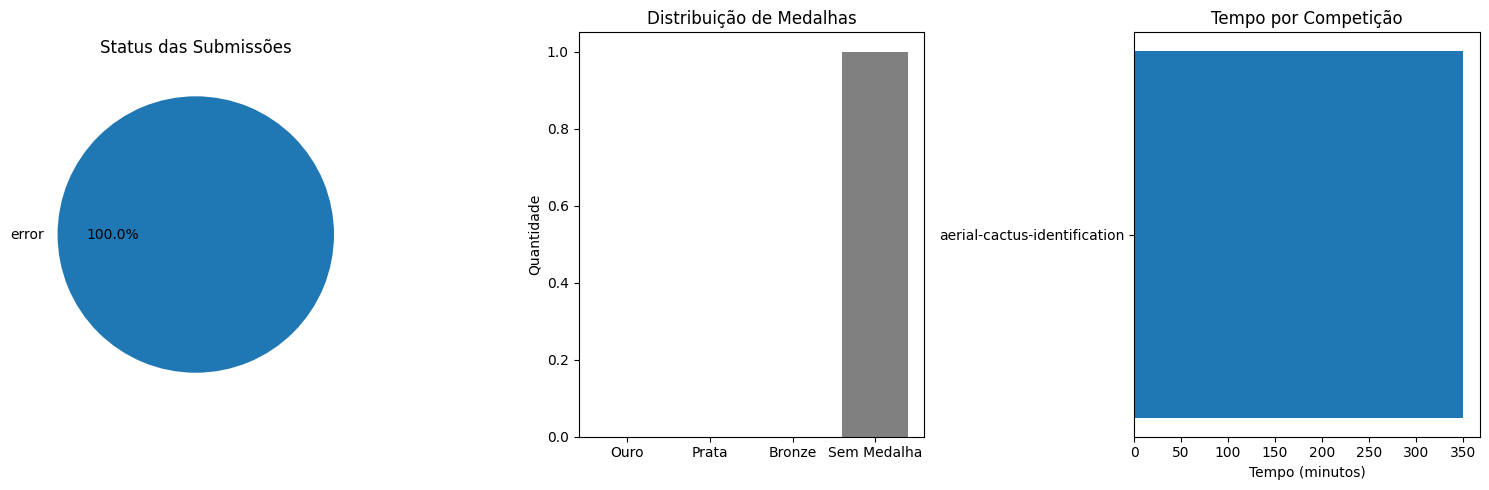


✓ Gráfico salvo em /content/mlebench_results_viz.png


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Status das submissões
status_counts = df_summary['Status'].value_counts()
axes[0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
axes[0].set_title('Status das Submissões')

# 2. Medalhas
medals = {
    'Ouro': len([r for r in all_results if r.get('mlebench_validation', {}).get('gold_medal')]),
    'Prata': len([r for r in all_results if r.get('mlebench_validation', {}).get('silver_medal')]),
    'Bronze': len([r for r in all_results if r.get('mlebench_validation', {}).get('bronze_medal')]),
    'Sem Medalha': len([r for r in all_results if not any([
        r.get('mlebench_validation', {}).get('gold_medal'),
        r.get('mlebench_validation', {}).get('silver_medal'),
        r.get('mlebench_validation', {}).get('bronze_medal')
    ])])
}
colors = ['gold', 'silver', '#CD7F32', 'gray']
axes[1].bar(medals.keys(), medals.values(), color=colors)
axes[1].set_title('Distribuição de Medalhas')
axes[1].set_ylabel('Quantidade')

# 3. Tempo por competição
df_time = df_summary[df_summary['Time (min)'] > 0].sort_values('Time (min)', ascending=True)
axes[2].barh(df_time['Competition'], df_time['Time (min)'])
axes[2].set_xlabel('Tempo (minutos)')
axes[2].set_title('Tempo por Competição')

plt.tight_layout()
plt.savefig('/content/mlebench_results_viz.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo em /content/mlebench_results_viz.png")